# Import libraries

In [ ]:
# mamba install gpy
# mamba install richdem

In [ ]:
pip install tensorflow

In [ ]:
pip install parameter-sherpa

In [ ]:
pip install shap

In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap

plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [3]:
url = 'gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-2020.zarr'
ds2020 = xr.open_dataset(url, engine='zarr', chunks={})

In [4]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1
jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 22
numberdaystot = numberyears * numberdays
n_feature = 20
n_lat = 415
n_lon = 230

In [5]:
LAT = ds2020.LAT.values
LON = ds2020.LON.values
AL2_2020 = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

In [6]:
SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

slope = rd.TerrainAttribute(SH_vals, attrib='slope_riserun')
aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00280891===================== ] (99% - 0.0s - 1 threads)===== ] (98% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0048163====================== ] (99% - 0.0s - 1 threads)


In [7]:
alg2016 = np.flipud(np.array(Image.open('./algae2016_MARproj_6_5km.tif')))
alg2017 = np.flipud(np.array(Image.open('./algae2017_MARproj_6_5km.tif')))
alg2016 = np.where(alg2016 == 0, np.nan, alg2016)
alg2017 = np.where(alg2017 == 0, np.nan, alg2017)

algnan = np.zeros((415,230))
algnan = np.where(algnan == 0, np.nan, np.nan)

In [39]:
# x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

# for i in range(22):
   
#     year = i + 2000
#     url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
#     ds = xr.open_dataset(url, engine='zarr', chunks={})
    
#     x[i,:,:,:,0] = ds.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,1] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,2] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,3] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,4] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,5] = ds.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,6] = ds.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,7] = ds.SP.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,8] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     x[i,:,:,:,9] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,10] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,11] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,12] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,13] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     x[i,:,:,:,14] = ds.SF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
#     for j in range(aug31-jun1+1):
#         x[i,j,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
#         x[i,j,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
#         x[i,j,:,:,17] = slope[:n_lat,:n_lon]
#         x[i,j,:,:,18] = aspect[:n_lat,:n_lon]
#         x[i,j,:,:,19] = algnan

# for k in range(aug31-jun1+1):
#     x[16,k,:,:,19] = alg2016
#     x[17,k,:,:,19] = alg2017

In [41]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, 2))

for i in range(22):
   
    year = i + 2000
    url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
    ds = xr.open_dataset(url, engine='zarr', chunks={})
    
    # x[i,:,:,:,0] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,1] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,0] = ds.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,1] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,2] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,3] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,0] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
    for j in range(aug31-jun1+1):
        x[i,j,:,:,0] = ds2020.SH.values[:n_lat,:n_lon]
        x[i,j,:,:,1] = slope[:n_lat,:n_lon]
        # x[i,j,:,:,2] = aspect[:n_lat,:n_lon]

In [42]:
# use only lower half
# x = x[:,:,:int(n_lat/2),:,:]
# x = x.reshape(numberdaystot, int(n_lat/2), n_lon, 3)

# use only lower left quadrant
x = x[:,:,:int(n_lat/2),:int(n_lon/2),:]
x = x.reshape(numberdaystot, int(n_lat/2), int(n_lon/2), 2)

In [43]:
np.shape(x)

(2024, 207, 115, 2)

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August

In [44]:
path = './MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[:]
dir_list

array(['20000601_albedo.tif', '20000602_albedo.tif',
       '20000603_albedo.tif', ..., '20210829_albedo.tif',
       '20210830_albedo.tif', '20210831_albedo.tif'], dtype='<U19')

#### Create nan arrays for days where I don't have MODIS data

In [45]:
modisnan = np.zeros((415,230))
modisnan = np.where(modisnan == 0, np.nan, np.nan)

#### Flip matrix right-side up and place in new matrix 'y'

In [46]:
y = np.zeros((numberdaystot,415,230,1))

for i in range(65):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(65,78):
    y[i,:,:,0] = modisnan

for i in range(78,107):
    f = dir_list[i-13]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(107,124):
    y[i,:,:,0] = modisnan

for i in range(124,numberdaystot):
    f = dir_list[i-29]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range

In [47]:
y = np.where(y == 255, np.nan, y)
y = y/100

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [48]:
ds_bie = sio.loadmat('./sboth_6km.mat')
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (2, 3, 0, 1))
bareice = bareice.reshape(numberdaystot, n_lat, n_lon)

#### Multiply with bare ice matrix to extract only bare ice albedo values

In [49]:
y = y[:,:,:,0] * bareice

#### Only use southern half or southwest quadrant

In [50]:
# use only lower half
# y = y[:,:int(n_lat/2),:]

# use only lower left quadrant
y = y[:,:int(n_lat/2),:int(n_lon/2)]

# Find 2-sigma ice albedo cut-off values for MODIS

In [51]:
mean = np.nanmean(y)
std = np.nanstd(y)
y_meanplus2sig = mean + 2 * std
y_meanminus2sig = mean - 2 * std
mean, std, y_meanminus2sig, y_meanplus2sig

(0.4236438593897879,
 0.12776467830319704,
 0.1681145027833938,
 0.679173215996182)

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [52]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
    
    mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
    
    x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std
    
    # if i == 9:
        # AL2_mean, AL2_std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])

x = x_dum

#### Create mask of valid albedo pixels and only use pixels that have a realistic albedo value (> 0.1)

In [53]:
# y_masknan = np.where(y > 0.1, 1, np.nan)
y_masknan = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)

y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,x.shape[1],x.shape[2],x.shape[3]))
for i in range(x.shape[3]):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan

In [421]:
# nonnans_2000_2015 = int(np.nansum(y_masknan[:92*16,:,:]))
# nonnans_2016_2017 = int(np.nansum(y_masknan[92*16:92*17,:,:]) + np.nansum(y_masknan[92*17:92*18,:,:]))
# nonnans_2018_2021 = int(np.nansum(y_masknan[92*18:,:,:]))

In [422]:
# x_dum = x_mask[92*16:92*18,:,:,19]
# x_dum = np.nan_to_num(x_dum, nan=0)
# x_mask[92*16:92*18,:,:,19] = x_dum * y_masknan[92*16:92*18,:,:]

In [54]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan = y_mask[~np.isnan(y_mask)]

# create zero matrix of same lenth as y_nonan, with space for all 20 features in x

# use only for lower half
# x_nonan = np.zeros((726996,x.shape[3]))
# use only for lower left quadrant
# x_nonan = np.zeros((511142,x.shape[3]))
x_nonan = np.zeros((494408,x.shape[3]))

# put values of x (where bareice==1) in x_nonan, for all MAR features (feat=(0,19))
# for i in range(19):
for i in range(x.shape[3]):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]


# ### put all non-nan algae values in x_nonan. there are only values for 2016 and 2017, so put nans in the other years but make sure it is the same length
# # create dummy array of the algae values
# x_mask_dum = x_mask[:,:,:,19]

# # create nan-arrays to be put in 2000-2015 and 2018-2021
# nans_2000_2015 = np.zeros((nonnans_2000_2015,1))
# nans_2018_2021 = np.zeros((nonnans_2018_2021,1))
# nans_2000_2015 = np.where(nans_2000_2015 == 0, np.nan, np.nan)
# nans_2018_2021 = np.where(nans_2018_2021 == 0, np.nan, np.nan)

# # put nans in x_nonan for 2000-2015
# x_nonan[:nonnans_2000_2015,19] = nans_2000_2015[:,0]
# # put non-nan algae values in x_nonan for 2016 and 2017
# x_nonan[nonnans_2000_2015:nonnans_2000_2015+nonnans_2016_2017,19] = x_mask_dum[~np.isnan(x_mask_dum)]
# # put nans in x_nonan for 2018-2021
# x_nonan[nonnans_2000_2015+nonnans_2016_2017:,19] = nans_2018_2021[:,0]

# x_nonan[:,19] = np.nan_to_num(x_nonan[:,19], nan=0)

In [ ]:
# remove algae data from x
# x_nonan = x_nonan[:,:18]

#### Split data into training (18/22) and testing (2/22) and validation (2/22)

In [55]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(2/22), shuffle=False)

In [56]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((449461, 2), (44947, 2), (449461,), (44947,))

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(2/20), shuffle=False)

In [58]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((404514, 2), (44947, 2), (404514,), (44947,))

# Initialize and run RF model

### Hyperparameter tuning

In [64]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 75, stop = 125, num = 3)]

# Minimum number of samples required to split a node
min_samples_split = [15, 20, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [8, 16, 24]

# Number of features to consider at every split
max_features = ['auto'] #, 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(25, 75, num = 3)]
# max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True] #, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [65]:
print(random_grid)

{'n_estimators': [75, 100, 125], 'max_features': ['auto'], 'max_depth': [25, 50, 75], 'min_samples_split': [15, 20, 25], 'min_samples_leaf': [8, 16, 24], 'bootstrap': [True]}


In [ ]:
reg0 = RandomForestRegressor(random_state=0)

# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 150, cv = 2, verbose=2, n_jobs = -1, scoring='accuracy') #cv=5
rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

### Run RF model

In [59]:
n_estimators      = 75   # Number of trees in random forest
min_samples_split = 15   # Minimum number of samples required to split a node
min_samples_leaf  = 8    # Minimum number of samples required at each leaf node
max_features      = 'auto' #'sqrt' # Number of features to consider at every split
max_depth         = 25   # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

In [60]:
reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

In [61]:
rf_tas = reg0.fit(X_train,y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


In [62]:
reg0.score(X_train,y_train), reg0.score(X_test,y_test), reg0.score(X_val,y_val)

(0.4392309620623156, 0.47955518795347507, 0.4116682550246824)

# Evaluate the model

In [31]:
y_test_pre = rf_tas.predict(X_test)

In [129]:
# AL2_test = (X_test[:,9] * AL2_std) + AL2_mean

#### Evaluation metrics for MODIS-RF

In [32]:
np.nanmean(y_test), np.nanmean(y_test_pre)

(0.4260633635170313, 0.4296142115382066)

In [37]:
R2_MODIS_RF = ma.corrcoef(y_test, y_test_pre)[1,0]**2
R2_MODIS_RF

0.49663669719991205

In [38]:
mean_squared_error(y_test, y_test_pre)

0.006212880886314514

In [39]:
# RMSE percentage
rmspe = np.sqrt(np.nanmean(np.square(((y_test - y_test_pre) / y_test)), axis=0))
rmspe

0.25051388445559447

#### Evaluation metrics for MODIS-MAR

In [211]:
R2_MODIS_MAR = ma.corrcoef(y_test, AL2_test)[1,0]**2
R2_MODIS_MAR

0.055336363964158045

In [133]:
mean_squared_error(y_test, AL2_test)

0.03430552347884957

In [ ]:
# RMSE percentage
rmspe = np.sqrt(np.nanmean(np.square(((y_test - AL2_test) / y_test)), axis=0))
rmspe

# Visualization

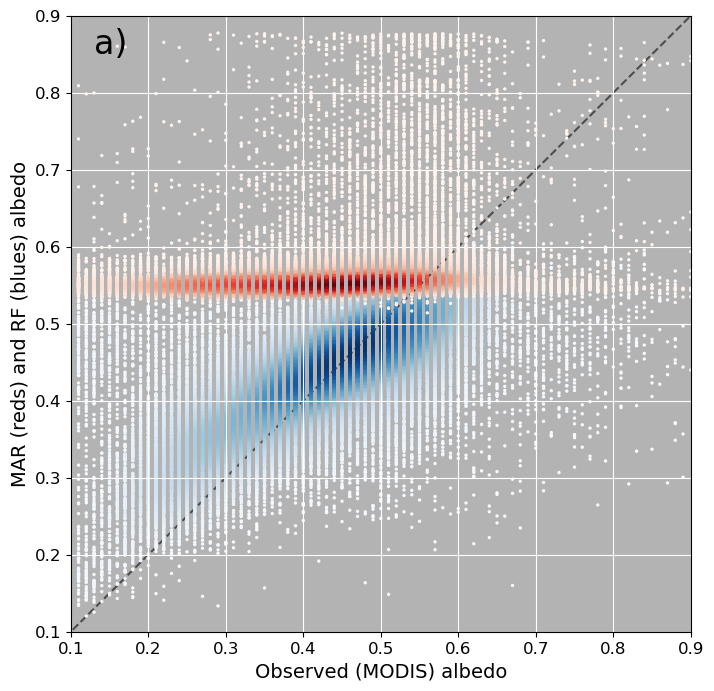

In [41]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, y_test_pre])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, AL2_test])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,1,0.1), np.arange(-1,1,0.1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, AL2_test, c=z2, s=2, zorder=2, cmap='Reds')
ax.text(0.13, 0.85, 'a)', fontsize=24)

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and RF (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=0)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

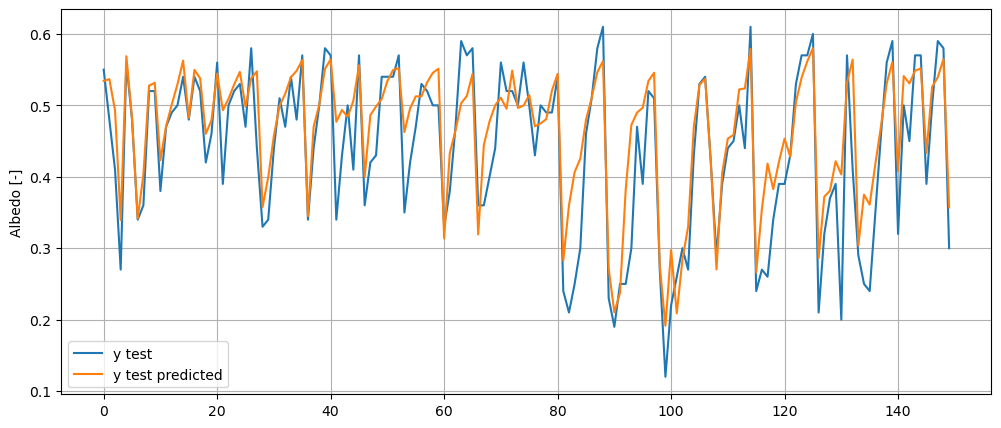

In [71]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:150], label='y test')
plt.plot(y_test_pre[:150], label='y test predicted')
# plt.xlabel('Days from 1 June 2020')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

# Shapley

In [ ]:
explainer = shap.Explainer(rf_tas.predict, X_train)
shap_values = explainer(X_test)

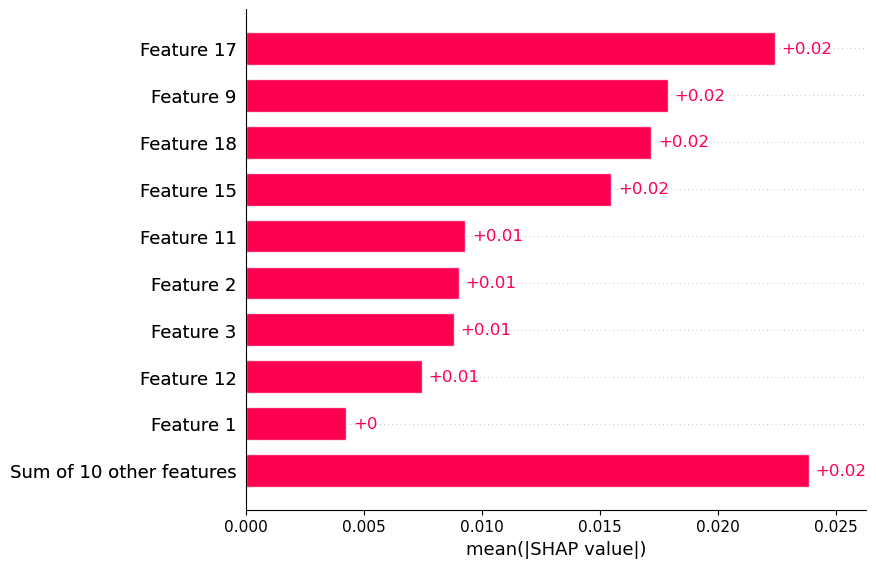

In [56]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


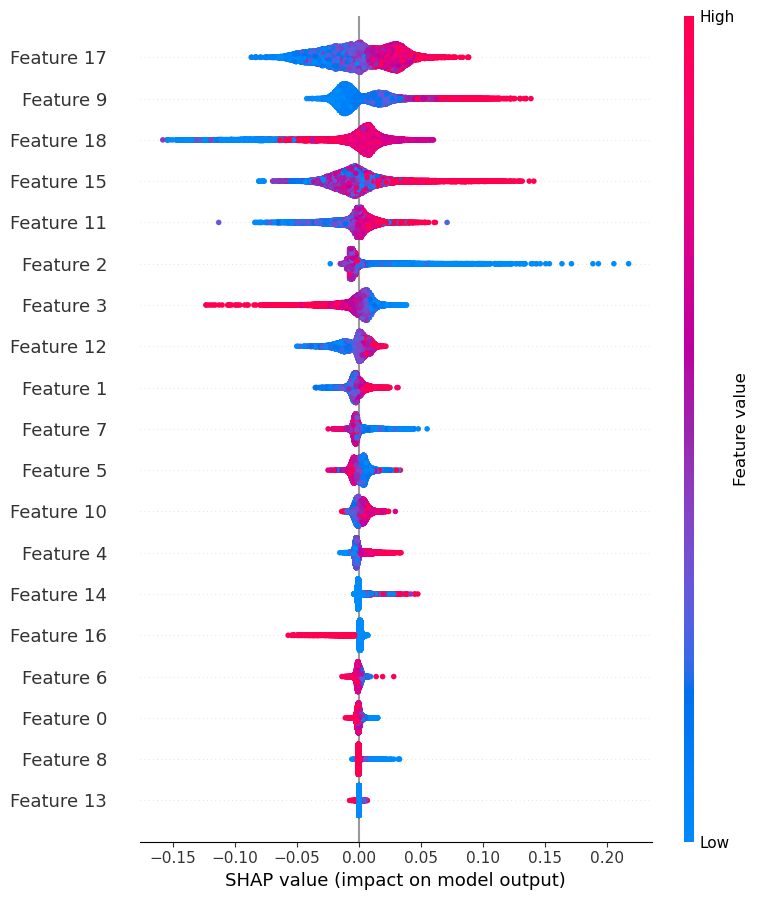

In [57]:
shap.summary_plot(shap_values)

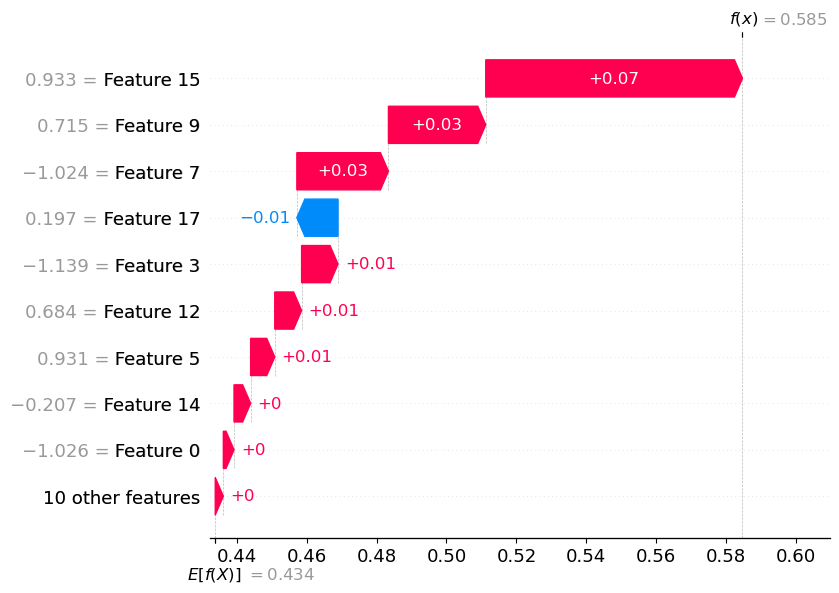

In [59]:
shap.plots.waterfall(shap_values[0])

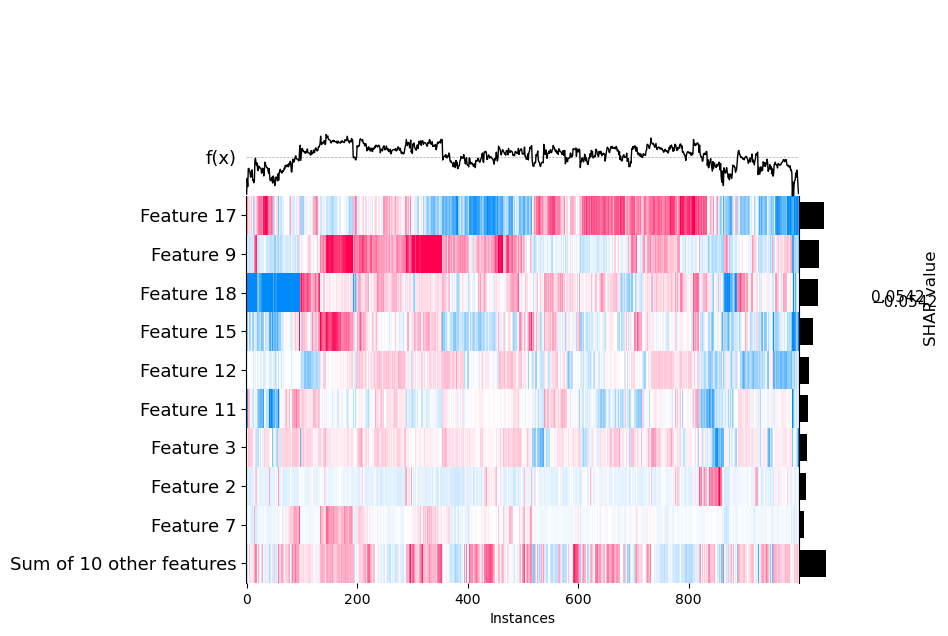

In [62]:
shap.plots.heatmap(shap_values[:1000])

# Equation Discovery

In [ ]:
# Create a graph
graph = tf.Graph()

# Create a session
with graph.as_default():
    sess = tf.Session()

# Create a variable
x = tf.Variable(1.0)

# Create a placeholder
y = tf.placeholder(tf.float32)

# Create an equation
equation = tf.equation_discovery.create_equation(x, y)

# Evaluate the equation
sess.run(equation)
